In [1]:
from popsims.evol_models import EVOL_MODELS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from numba import njit


import numpy as np
import pandas as pd
from popsims import fast_2d_interpolation
%matplotlib inline

In [2]:
class EvolutionaryModel:
    def __init__(self,  dataframe, columns=['mass', 'age', 'metallicity', 'temperature']):
        #initialize model 
        assert all(column in dataframe.columns for column in columns), "DataFrame is missing required columns"
        self.columns=np.array(dataframe.columns)
        self.data = dataframe[self.columns].values
        self.required_columns=columns

    def interpolate(self, x_axis, y_axis, x_values, y_values, logscale=['mass', 'age', 'temperature']):
        assert x_axis in self.columns, f"x_axis '{x_axis}' not found in DataFrame columns"
        assert y_axis in self.columns, f"y_axis '{y_axis}' not found in DataFrame columns"
        
        #make a copy of data 
        #put stuff on logscale
        dt= self.data.copy()
        for c in logscale:
            col_idx = np.where(self.columns == c)[0][0]
            dt[:, col_idx] =np.log10(np.array(dt[:, col_idx]).astype(float))
            
        points = dt[:, [np.where(self.columns == x_axis)[0][0], np.where(self.columns == y_axis)[0][0]]]
        remaining_columns = [col for col in self.required_columns if col not in [x_axis, y_axis]]
        results = {}
        
        for col in remaining_columns:
            col_idx = np.where(self.columns == col)[0][0]
            values =dt[:, col_idx]
            #result = np.empty_like(y_values)
            #interp_values= interpolate_2d(points, values, x_values, y_values, result)
            results[col] = fast_2d_interpolation(points, values, x_values, y_values)
            
        interp_df= pd.DataFrame(results)
        interp_df[x_axis]=x_values
        interp_df[y_axis]=y_values
        return interp_df

In [3]:
from popsims.evol_models import EVOL_MODELS

In [4]:
EVOL_MODELS['marley2019'].keys()

dict_keys(['mass', 'age', 'luminosity', 'temperature', 'gravity', 'radius'])

In [5]:
df=pd.DataFrame(EVOL_MODELS['burrows1997'])
m= EvolutionaryModel(df, columns=['mass', 'age', 'temperature'])
mass=np.random.uniform(-2, 1, 100000)
age=np.random.uniform(-2.5, 1., 100000)
res=m.interpolate('mass','age', mass, age)

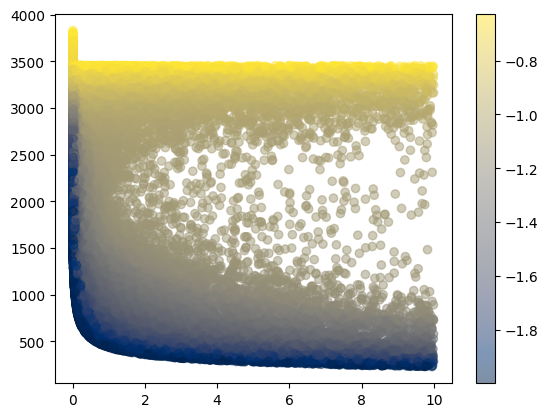

In [6]:
fig, ax=plt.subplots()
c=ax.scatter(10**age, 10**res.temperature.values,  c=mass, alpha=0.5, cmap='cividis')

plt.colorbar(c)

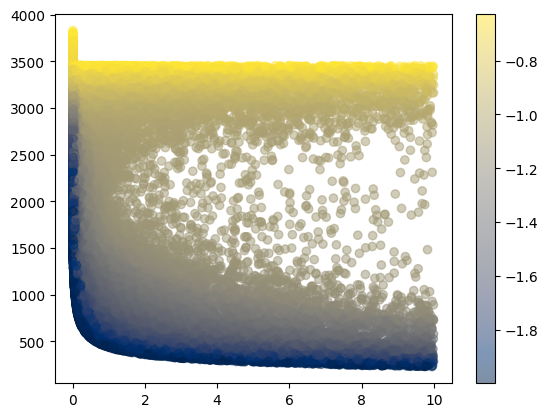

In [7]:
res=m.interpolate('mass','age', mass, age)
fig, ax=plt.subplots()
c=ax.scatter(10**age, 10**res.temperature.values,  c=mass, alpha=0.5, cmap='cividis')

plt.colorbar(c)

In [8]:
def interpolate_evolutionary_model(Model, mass, age, additional_columns=[]):
    #first remove nans
    lmass=mass
    lage=age


    res=Model.interpolate('mass','age', lmass, lage, logscale=['mass', 'age', 'temperature'])
    #return evolutionary_model_interpolator(mass, age, self.evolmodel)
    res['mass']=10**lmass
    res['age']=10**lage
    res['temperature']=10**res.temperature.values
    return res


In [9]:
mor=interpolate_evolutionary_model(m, mass, age, additional_columns=[])

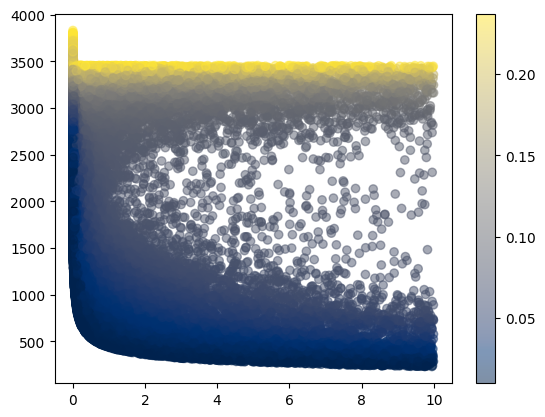

In [10]:
fig, ax=plt.subplots()
c=ax.scatter(mor.age, mor.temperature.values,  c=mor.mass, alpha=0.5, cmap='cividis')

plt.colorbar(c)

In [11]:
#--> create a fast interpolation classs
#--> include/rearrange Roman's models
#--> rerun simulations with metallicities as input